# Задание 2. {*} 3 балла

Реализуйте медианный фильтр.

Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
сортируются, и выбирается медианное значение из отсортированного массива. 

Это значение и является выходным для текущего пикселя.

Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [4]:
import torch
import torchvision.io
import matplotlib.pyplot as plt
import os


In [5]:
def median_filter(image: torch.Tensor, kernel_size: int) -> torch.Tensor:
    """
    Applies median filter to the image using pure torch.

    Args:
        image: Tensor of shape (C, H, W)
        kernel_size: int, size of the kernel

    Returns:
        Filtered image tensor of shape (C, H, W)
    """
    C, H, W = image.shape
    padding = kernel_size // 2

    # Create padded image manually to avoid torch.nn
    # We use replication padding (repeating boundary pixels)
    padded_H = H + 2 * padding
    padded_W = W + 2 * padding
    padded_image = torch.zeros((C, padded_H, padded_W), dtype=image.dtype, device=image.device)

    # Place original image in the center
    padded_image[:, padding:padding+H, padding:padding+W] = image

    # Fill borders (Replication padding)
    # Top
    padded_image[:, :padding, padding:padding+W] = image[:, :1, :]
    # Bottom
    padded_image[:, padding+H:, padding:padding+W] = image[:, -1:, :]
    # Left (including corners)
    padded_image[:, :, :padding] = padded_image[:, :, padding:padding+1]
    # Right (including corners)
    padded_image[:, :, padding+W:] = padded_image[:, :, padding+W-1:padding+W]

    # Extract sliding windows using unfold
    # unfold(dimension, size, step)
    # First unfold height: (C, H_out, W_padded, kernel_size)
    # Second unfold width: (C, H_out, W_out, kernel_size, kernel_size)
    patches = padded_image.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1)

    # patches shape is now (C, H_out, W_out, k, k)
    # Check output dimensions
    H_out = patches.shape[1]
    W_out = patches.shape[2]

    # Reshape to (C, H_out, W_out, k*k) to compute median over the kernel
    patches = patches.contiguous().view(C, H_out, W_out, -1)

    # Compute median
    # torch.median returns (values, indices)
    median_values = patches.median(dim=-1).values

    # If kernel_size is even, the output size might be slightly different due to padding logic
    # For k=10, pad=5. H_out = H + 10 - 10 + 1 = H + 1.
    # We need to crop to original size H, W
    if H_out > H:
        median_values = median_values[:, :H, :]
    if W_out > W:
        median_values = median_values[:, :, :W]

    return median_values


Applying median filter with kernel size 3...
Applying median filter with kernel size 5...
Applying median filter with kernel size 10...
Results saved to median_filter_results.png


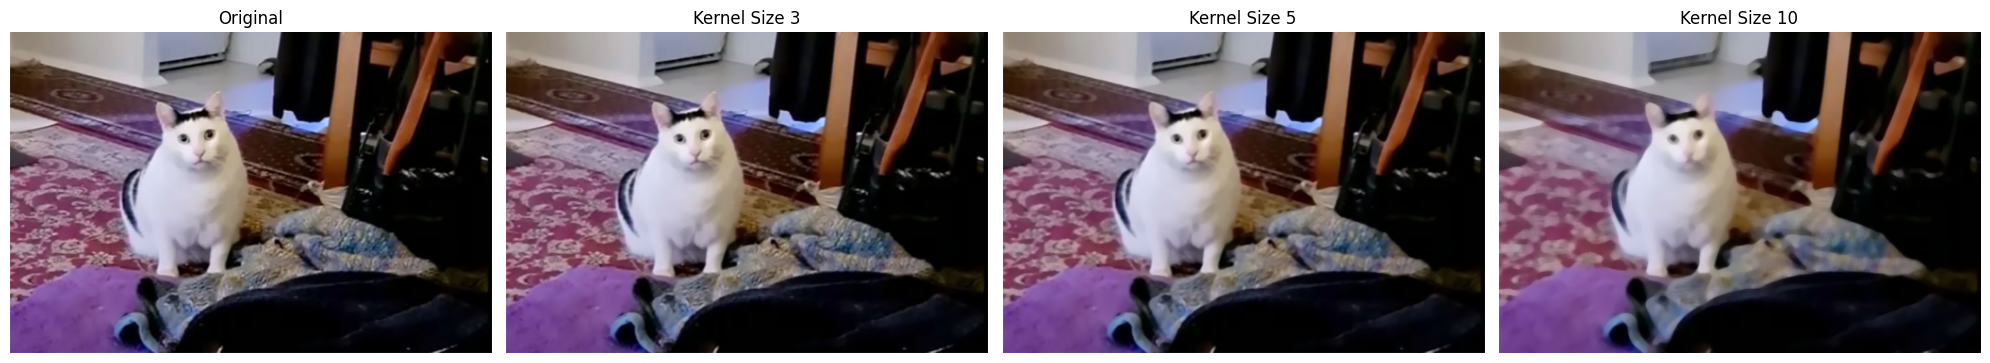

In [8]:
image_path = '../../images/kot_mjaukaet.jpg'
img = torchvision.io.read_image(image_path)
img = img.float() / 255.0

kernel_sizes = [3, 5, 10]

# Setup plot
fig, axes = plt.subplots(1, len(kernel_sizes) + 1, figsize=(20, 6))

# Show original
axes[0].imshow(img.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original")
axes[0].axis('off')

for i, k in enumerate(kernel_sizes):
	print(f"Applying median filter with kernel size {k}...")

	filtered_img = median_filter(img, k)

	# Clamp values to [0, 1] just in case
	filtered_img = torch.clamp(filtered_img, 0, 1)

	axes[i+1].imshow(filtered_img.permute(1, 2, 0).cpu().numpy())
	axes[i+1].set_title(f"Kernel Size {k}")
	axes[i+1].axis('off')

output_file = 'median_filter_results.png'
plt.tight_layout()
plt.savefig(output_file)
print(f"Results saved to {output_file}")
plt.show()
